### Étape 1: Importation des bibliothèques nécessaires

In [ ]:

import cv2 # Importation de la bibliothèque OpenCV pour le traitement d'image
import os # Importation de la bibliothèque OS pour interagir avec le système de fichiers (ex : parcourir des dossiers)
import numpy as np # Importation de NumPy pour les opérations mathématiques sur les matrices/tableaux
import pandas as pd # Importation de pandas pour gérer des tableaux de données (DataFrames)
from skimage.feature import hog # Importation de la fonction HOG (Histogram of Oriented Gradients) pour l'extraction de caractéristiques visuelles
from sklearn.decomposition import PCA # Importation de PCA (analyse en composantes principales) pour la réduction de dimensionnalité
from sklearn.preprocessing import StandardScaler # Importation de StandardScaler pour normaliser les données (moyenne 0, écart-type 1)
import joblib # Importation de joblib pour sauvegarder et charger des modèles ou des objets Python (plus rapide que pickle pour des objets volumineux)
import matplotlib.pyplot as plt # Importation de matplotlib pour afficher des courbes, images ou graphiques
# Importation du classifieur SVM (Support Vector Classifier)
from sklearn.svm import SVC

# Importation de joblib pour sauvegarder ou charger un modèle entraîné
import joblib

# Importation des métriques pour évaluer les performances du modèle
from sklearn.metrics import (
    recall_score,          # Sensibilité : proportion de vrais positifs détectés
    roc_auc_score,         # Aire sous la courbe ROC : mesure de la performance globale du modèle
    precision_score,       # Précision : proportion de prédictions positives correctes
    accuracy_score,        # Exactitude : proportion totale de bonnes prédictions
    roc_curve,             # Courbe ROC : courbe TPR vs FPR
    
)

# Importation des outils de validation croisée
from sklearn.model_selection import (
    cross_val_score,       # Renvoie les scores de validation croisée pour un modèle
    GridSearchCV,          # Recherche des meilleurs hyperparamètres avec validation croisée
    cross_val_predict      # Renvoie les prédictions de validation croisée pour chaque échantillon
)


### Étape 2: Définir le chemin vers les dossiers d'images d'entraînement et de test

In [17]:

base_dir = './Dataset_Préparer'
directory_train = os.path.join(base_dir, 'Data_Train')
directory_test = os.path.join(base_dir, 'Data_Test')
print("Chemin train :", directory_train)
print("Chemin test :", directory_test)


Chemin train : ./Dataset_Préparer\Data_Train
Chemin test : ./Dataset_Préparer\Data_Test


### Étape 3 : Chargement des identifiants d'images à partir des fichiers CSV pour les ensembles d'entraînement et de test

In [19]:
# Fonction pour charger les noms de fichiers à partir des fichiers CSV
def load_image_id(csv_file):
    return pd.read_csv(csv_file)['image_id'].tolist()

# Charger les noms des images saines et malades
saines_images = load_image_id('./Dataset_Préparer/Data_Train/feuilles_saines.csv')
malades_images = load_image_id('./Dataset_Préparer/Data_Train/feuilles_malades.csv')

# Charger les noms des images de test (même format CSV avec colonne "image_id")
test_images = load_image_id('./Dataset_Préparer/Data_Test/test.csv')

# Vérification des noms de fichiers chargés
print("Images saines chargées:", saines_images[:5])  # Afficher les 5 premiers noms
print("Images malades chargées:", malades_images[:5])  # Afficher les 5 premiers noms
print("Images de test chargées:", test_images[:5])    # Afficher les 5 premiers noms


Images saines chargées: ['Train_2', 'Train_4', 'Train_5', 'Train_9', 'Train_13']
Images malades chargées: ['Train_0', 'Train_1', 'Train_3', 'Train_6', 'Train_7']
Images de test chargées: ['Test_0', 'Test_1', 'Test_2', 'Test_3', 'Test_4']


### Étape 4: Définition de la fonction d'extraction des descripteurs HOG à partir des images

In [22]:


# Fonction pour extraire les descripteurs HOG à partir d'une image redimensionnée
def get_hog_descriptors_from_image(image, target_size=(128, 128)):
    # Redimensionnement de l'image 
    img_scaled = cv2.resize(image, target_size)
    
    # Convertir l'image redimensionnée en niveaux de gris 
    if len(img_scaled.shape) > 2:
        img_scaled = cv2.cvtColor(img_scaled, cv2.COLOR_BGR2GRAY)
    
    # Extraction des caractéristiques HOG de l'image redimensionnée
    features = hog(img_scaled, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), visualize=False,
                transform_sqrt=True, block_norm='L2-Hys')
    
    # Affichage pour vérification
    print(f"Caractéristiques HOG extraites avec succès pour une image de taille {image.shape} (redimensionnée à {target_size})")

    return features


### Étape 5: Prétraitement des données d'entraînement : Lecture robuste et  Extraction des descripteurs HOG 

In [25]:

# fonction de lecture d'image
def safe_imread(image_path):
    # Essayer de lire avec cv2
    img = cv2.imread(image_path)
    if img is not None:
        return img
    
    # Si échec, essayer en forçant le chemin Unicode sous Windows
    try:
        with open(image_path, 'rb') as f:
            bytes = bytearray(f.read())
            numpyarray = np.asarray(bytes, dtype=np.uint8)
            img = cv2.imdecode(numpyarray, cv2.IMREAD_COLOR)
            return img
    except Exception as e:
        print(f"Échec critique de lecture : {image_path} | Erreur : {str(e)}")
        return None

hog_features_train = []
train_labels = []
# Parcours des images saines
for image_id in saines_images:
    image_path = os.path.join(directory_train, 'Feuilles_Healthy', f"{image_id}.jpg")
    image_path = os.path.normpath(image_path)

    image = safe_imread(image_path)

    if image is not None:
        try:
            hog_features = get_hog_descriptors_from_image(image)
            hog_features_train.append(hog_features)
            train_labels.append(0)
        except Exception as e:
            print(f"Échec du traitement HOG : {image_path} | Erreur : {str(e)}")
    else:
        print(f"ERREUR: Impossible de lire {image_path} (existe: {os.path.exists(image_path)})")

saines_count = sum(1 for label in train_labels if label == 0)


# Parcours des images malades
malades_processed = 0
for image_id in malades_images:
    image_path = os.path.join(directory_train, 'Feuilles_Malades', f"{image_id}.jpg")
    image_path = os.path.normpath(image_path)

    image = safe_imread(image_path)

    if image is not None:
        try:
            hog_features = get_hog_descriptors_from_image(image)
            hog_features_train.append(hog_features)
            train_labels.append(1)
            malades_processed += 1
        except Exception as e:
            print(f"Échec du traitement HOG : {image_path} | Erreur : {str(e)}")
    else:
        print(f"ERREUR: Impossible de lire {image_path} (existe: {os.path.exists(image_path)})")



# Conversion en tableaux NumPy
X_train = np.array(hog_features_train)
y_train = np.array(train_labels)


# Résumé

print(f" ✔️Images saines traitées avec succès : {saines_count}/{len(saines_images)}")
print(f" ✔️ Images malades traitées avec succès : {malades_processed}/{len(malades_images)}")
print(f" ✔️TOTAL images traitées : {len(train_labels)} (saines: {saines_count} | malades: {malades_processed})")
print(f"\nRésultats finaux :")
print(f"- Shape X_train : {X_train.shape}")
print(f"- Shape y_train : {y_train.shape}")
print(f"- Ratio saines/malades : {np.sum(y_train == 0)/len(y_train):.2%} / {np.sum(y_train == 1)/len(y_train):.2%}")



Caractéristiques HOG extraites avec succès pour une image de taille (1365, 2048, 3) (redimensionnée à (128, 128))
Caractéristiques HOG extraites avec succès pour une image de taille (1365, 2048, 3) (redimensionnée à (128, 128))
Caractéristiques HOG extraites avec succès pour une image de taille (1365, 2048, 3) (redimensionnée à (128, 128))
Caractéristiques HOG extraites avec succès pour une image de taille (1365, 2048, 3) (redimensionnée à (128, 128))
Caractéristiques HOG extraites avec succès pour une image de taille (1365, 2048, 3) (redimensionnée à (128, 128))
Caractéristiques HOG extraites avec succès pour une image de taille (1365, 2048, 3) (redimensionnée à (128, 128))
Caractéristiques HOG extraites avec succès pour une image de taille (1365, 2048, 3) (redimensionnée à (128, 128))
Caractéristiques HOG extraites avec succès pour une image de taille (1365, 2048, 3) (redimensionnée à (128, 128))
Caractéristiques HOG extraites avec succès pour une image de taille (1365, 2048, 3) (red

 ### Étape 6: Prétraitement des données de test :Lecture robuste et Extraction des descripteurs HOG pour les images 

In [27]:
# Extraction des descripteurs HOG pour les images de test
hog_features_test = []

for image_name in test_images:
    image_path = os.path.join(directory_test, 'images_test', f"{image_name}.jpg")  
    image_path = os.path.normpath(image_path)

    image = safe_imread(image_path)

    if image is not None:
        try:
            hog_features = get_hog_descriptors_from_image(image)
            hog_features_test.append(hog_features)
        except Exception as e:
            print(f"Erreur lors de l'extraction HOG (test) : {image_path} | {str(e)}")
    else:
        print(f"Image de test non lue : {image_path}")

# Conversion en tableau numpy
X_test = np.array(hog_features_test)
print(f"\nNombre total d'images de test traitées : {X_test.shape[0]}")
print(f"Dimensions des descripteurs HOG test : {X_test.shape}")

Caractéristiques HOG extraites avec succès pour une image de taille (1365, 2048, 3) (redimensionnée à (128, 128))
Caractéristiques HOG extraites avec succès pour une image de taille (1365, 2048, 3) (redimensionnée à (128, 128))
Caractéristiques HOG extraites avec succès pour une image de taille (1365, 2048, 3) (redimensionnée à (128, 128))
Caractéristiques HOG extraites avec succès pour une image de taille (1365, 2048, 3) (redimensionnée à (128, 128))
Caractéristiques HOG extraites avec succès pour une image de taille (1365, 2048, 3) (redimensionnée à (128, 128))
Caractéristiques HOG extraites avec succès pour une image de taille (1365, 2048, 3) (redimensionnée à (128, 128))
Caractéristiques HOG extraites avec succès pour une image de taille (1365, 2048, 3) (redimensionnée à (128, 128))
Caractéristiques HOG extraites avec succès pour une image de taille (1365, 2048, 3) (redimensionnée à (128, 128))
Caractéristiques HOG extraites avec succès pour une image de taille (1365, 2048, 3) (red

### Étape 7: Réduction de dimension par PCA et normalisation des descripteurs HOG

In [18]:

# --- Standardisation ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✔️ Standardisation appliquée sur les données brutes.")

# --- Réduction de dimension avec PCA - conserver 90% de la variance ---
pca = PCA(n_components=0.90)
pca.fit(X_train_scaled)
print(f"✔️ PCA entraînée avec succès sur les données standardisées (variance expliquée : {sum(pca.explained_variance_ratio_):.2%}).")

# Transformation des données standardisées avec PCA
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print("✔️ Données standardisées projetées avec PCA.")

# --- Affichage des formes finales ---
print(f"✅ Dimensions finales après standardisation et PCA :")
print(f"📐 Ensemble d'entraînement : {X_train_pca.shape}")
print(f"📐 Ensemble de test : {X_test_pca.shape}")


✔️ Standardisation appliquée sur les données brutes.
✔️ PCA entraînée avec succès sur les données standardisées (variance expliquée : 90.01%).
✔️ Données standardisées projetées avec PCA.
✅ Dimensions finales après standardisation et PCA :
📐 Ensemble d'entraînement : (2610, 1005)
📐 Ensemble de test : (1821, 1005)


 ###  Étape 8: Entrainement et Evaluation de pérformances de modèle de SVM

Meilleurs paramètres SVM : {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Précision moyenne (SVM optimisé - Validation croisée) : 0.6800766283524904

Métriques supplémentaires sur l'ensemble d'entraînement (validation croisée):
Recall (Sensibilité): 0.8123
Precision: 0.6424
AUC-ROC: 0.7241


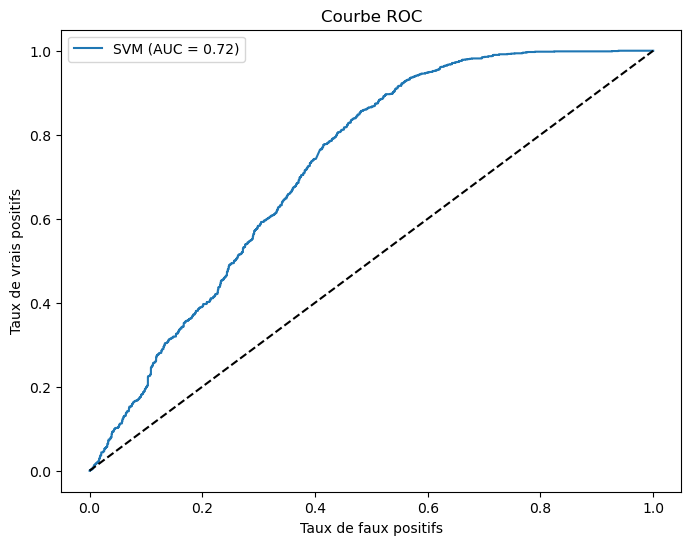

In [ ]:
# --- Modèle SVM pour la classification des feuilles saines/malades ---
print("\n🔍 Entraînement du modèle SVM ...")
# --- Étape 1 : Recherche des meilleurs hyperparamètres pour SVM ---
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.001, 0.0001],
    'kernel': ['rbf','lineaire']
}

# Création du modèle de base
base_model = SVC(probability=True, random_state=42)

# GridSearchCV avec validation croisée
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres SVM :", grid_search.best_params_)

# Récupérer le meilleur modèle trouvé
svm_model = grid_search.best_estimator_

# Évaluer la précision moyenne
scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
mean_accuracy = scores.mean()
print("Précision moyenne (SVM optimisé - Validation croisée) :", mean_accuracy)
# Prédictions pour les métriques supplémentaires
y_pred = cross_val_predict(svm_model, X_train_scaled, y_train, cv=5)
y_proba = cross_val_predict(svm_model, X_train_scaled, y_train, cv=5, method='predict_proba')[:, 1]

# Calcul des métriques
recall = recall_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
auc_roc = roc_auc_score(y_train, y_proba)


print(f"\nMétriques supplémentaires sur l'ensemble d'entraînement (validation croisée):")
print(f"Recall (Sensibilité): {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")


# Affichage de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_train, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'SVM (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend()
plt.show()




### Étape 9: Sauvegarde et réutilisation des modèles entraînés

In [ ]:
# Chemin du dossier où sauvegarder les modèles
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

# Entraînement final sur toutes les données
svm_model.fit(X_train_scaled, y_train)

# Sauvegarde des modèles
joblib.dump(scaler, os.path.join(model_dir, 'scaler.pkl'))
joblib.dump(pca, os.path.join(model_dir, 'pca.pkl'))
joblib.dump(svm_model, os.path.join(model_dir, 'svm.pkl'))

# Fonction pour charger les modèles
def load_models():
    scaler = joblib.load(os.path.join(model_dir, 'scaler.pkl'))
    pca = joblib.load(os.path.join(model_dir, 'pca.pkl'))
    svm_model = joblib.load(os.path.join(model_dir, 'svm.pkl'))
    return scaler, pca, svm_model

### Étape 10: Prédiction sur des Images de Feuilles de test


🖼️ Image : Test_1.jpg
⚠️ Prédit : MALADE


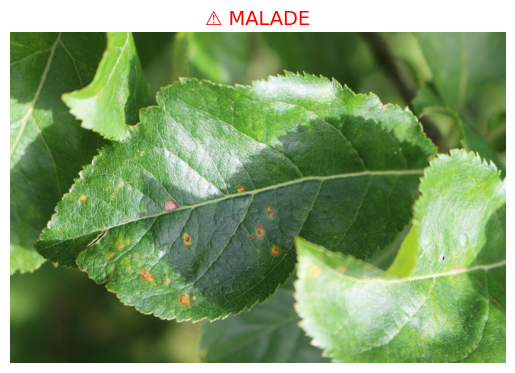

In [85]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
import joblib

# === Fonction pour charger les modèles sauvegardés ===
def load_models():
    model_dir = 'models'
    scaler = joblib.load(os.path.join(model_dir, 'scaler.pkl'))
    pca = joblib.load(os.path.join(model_dir, 'pca.pkl'))
    svm_model = joblib.load(os.path.join(model_dir, 'svm.pkl'))
    return scaler, pca, svm_model

# === Fonction pour extraire les caractéristiques HOG d'une image redimensionnée ===
def  get_hog_descriptors_from_image(image, target_size=(128, 128)):
    img_scaled = cv2.resize(image, target_size)
    if len(img_scaled.shape) > 2:
        img_scaled = cv2.cvtColor(img_scaled, cv2.COLOR_BGR2GRAY)
    features = hog(img_scaled, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False,
                   transform_sqrt=True, block_norm='L2-Hys')
    return features

# === Fonction de lecture robuste d'image ===
def safe_imread(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        return img
    try:
        with open(image_path, 'rb') as f:
            bytes = bytearray(f.read())
            numpyarray = np.asarray(bytes, dtype=np.uint8)
            img = cv2.imdecode(numpyarray, cv2.IMREAD_COLOR)
            return img
    except Exception as e:
        print(f"Erreur lecture image : {str(e)}")
        return None

# === Chargement des modèles sauvegardés ===
scaler, pca, svm_model = load_models()

# === Sélection d'une image à prédire ===
filename = "Test_1.jpg"  
healthy_path = "./Dataset_Préparer/Data_Test/images_test"  
image_path = os.path.join(healthy_path, filename)

# === Lecture de l'image ===
image = safe_imread(image_path)

if image is not None:
    try:
        # 1. Extraire les caractéristiques HOG
        hog_features =  get_hog_descriptors_from_image(image)

        # 2. Réduction de dimension avec PCA
        hog_reduced = pca.transform([hog_features])

        # 3. Normalisation des données
        hog_scaled = scaler.transform(hog_reduced)

        # 4. Prédiction avec le modèle SVM
        prediction = svm_model.predict(hog_scaled)

        # 5. Affichage des résultats
        print(f"\n🖼️ Image : {filename}")
        if prediction[0] == 0:
            print("✅ Prédit : SAINE")
        else:
            print("⚠️ Prédit : MALADE")

        # Affichage de l'image avec la prédiction
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("✅ SAINE" if prediction[0] == 0 else "⚠️ MALADE", 
                  fontsize=14, color='green' if prediction[0] == 0 else 'red')
        plt.show()

    except Exception as e:
        print(f"❌ Erreur traitement {filename} : {str(e)}")
else:
    print("❌ Impossible de lire l'image.")



🖼️ Image : Test_3.jpg
✅ Prédit : SAINE


C:\Users\utilisateur\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


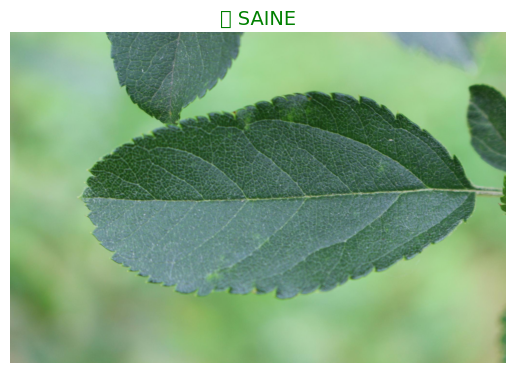

In [89]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
import joblib

# === Fonction pour charger les modèles sauvegardés ===
def load_models():
    model_dir = 'models'
    scaler = joblib.load(os.path.join(model_dir, 'scaler.pkl'))
    pca = joblib.load(os.path.join(model_dir, 'pca.pkl'))
    svm_model = joblib.load(os.path.join(model_dir, 'svm.pkl'))
    return scaler, pca, svm_model

# === Fonction pour extraire les caractéristiques HOG d'une image redimensionnée ===
def  get_hog_descriptors_from_image(image, target_size=(128, 128)):
    img_scaled = cv2.resize(image, target_size)
    if len(img_scaled.shape) > 2:
        img_scaled = cv2.cvtColor(img_scaled, cv2.COLOR_BGR2GRAY)
    features = hog(img_scaled, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False,
                   transform_sqrt=True, block_norm='L2-Hys')
    return features

# === Fonction de lecture robuste d'image ===
def safe_imread(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        return img
    try:
        with open(image_path, 'rb') as f:
            bytes = bytearray(f.read())
            numpyarray = np.asarray(bytes, dtype=np.uint8)
            img = cv2.imdecode(numpyarray, cv2.IMREAD_COLOR)
            return img
    except Exception as e:
        print(f"Erreur lecture image : {str(e)}")
        return None

# === Chargement des modèles sauvegardés ===
scaler, pca, svm_model = load_models()

# === Sélection d'une image à prédire ===
filename = "Test_3.jpg"  
healthy_path = "./Dataset_Préparer/Data_Test/images_test"  
image_path = os.path.join(healthy_path, filename)

# === Lecture de l'image ===
image = safe_imread(image_path)

if image is not None:
    try:
        # 1. Extraire les caractéristiques HOG
        hog_features =  get_hog_descriptors_from_image(image)

        # 2. Réduction de dimension avec PCA
        hog_reduced = pca.transform([hog_features])

        # 3. Normalisation des données
        hog_scaled = scaler.transform(hog_reduced)

        # 4. Prédiction avec le modèle SVM
        prediction = svm_model.predict(hog_scaled)

        # 5. Affichage des résultats
        print(f"\n🖼️ Image : {filename}")
        if prediction[0] == 0:
            print("✅ Prédit : SAINE")
        else:
            print("⚠️ Prédit : MALADE")

        # Affichage de l'image avec la prédiction
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("✅ SAINE" if prediction[0] == 0 else "⚠️ MALADE", 
                  fontsize=14, color='green' if prediction[0] == 0 else 'red')
        plt.show()

    except Exception as e:
        print(f"❌ Erreur traitement {filename} : {str(e)}")
else:
    print("❌ Impossible de lire l'image.")
